In [74]:
import sys
assert sys.version_info >= (3,10)
import sklearn
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt



# Analyzing California House Pricing from 1990 Census

### Type of Machine Learning
- This is a supervised learning task with labeled data.
- Multiple Regression as dataset contains multiple input features
- Univariate: Only trying to predict single value for each district
- Batch Learning as there is no continuous flow of data + Data small enough to fit in memory

### Performance Measure
- We will be using RMSE as our performance measure
$$\text{RMSE}(\mathbf{X},\mathbf{y},h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(\mathbf{x}^{(i)})-y^{(i)})^2}$$
Where:
- m is number of intances in dataset you are measuring RMSE on
- $x^{(i)}$ is vector containing all feature value except label
- $y^{(i)}$ is the label vector for the ith instance
- big X is matrix containing all feature values excluding labels in dataseet
- h is hypothesis function
- RMSE is the cost function

### Getting Data
- Can download from web as csv or from a url

In [75]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

### Take a quick look at data
Use pd head() method to look at the top 5 rows of dataset
- There are 10 attributes
    1. Longitude
    2. Latitude
    3. Housing Median Age
    4. Total rooms
    5. Total bedrooms
    6. Population
    7. Households
    8. Median Income
    9. Median House Value
    10. Ocean Proximity

In [76]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Use the pd info() method to get quick description of data
- Number of rows
- Types
- Number of non null values

See that `total_bedrooms` only has 20,433 non-null values, 207 are missing, will need to take care of that later

See that `ocean_proximity` is a type object. Because it was loaded from a csv file, it must be a text attribute.

In [77]:
housing_full.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  str    
dtypes: float64(9), str(1)
memory usage: 1.6 MB


When you look at `ocean_proxmity`, it seems to be repetative, which indicates that it is a categorical attribute. Can see what categories exist using the `values_counts()` method

In [78]:
housing_full["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

The `describe()` method shows summary of numerical attributes including count, mean, std etc..

In [79]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another way to have a better feel of the data is to graph it using the pd `hist()` method and matplotlib

You will notice that:
- Median is expressed in 10,000s --> Data was preprocessed
- Housing median age and value seems to be capped, will pose a problem to your machine learning algorithm as it may learn that prices can never go above that limit.
    - To fix, can collect proper labeles for capped districts or remove them from training & test sets. (Means system should not be used to predict values > 500k)
- Each attribute uses different scales (feature scaling)
- Many of the histograms are skewed right, will make it harder for ML algorithms to learn / detect patterns

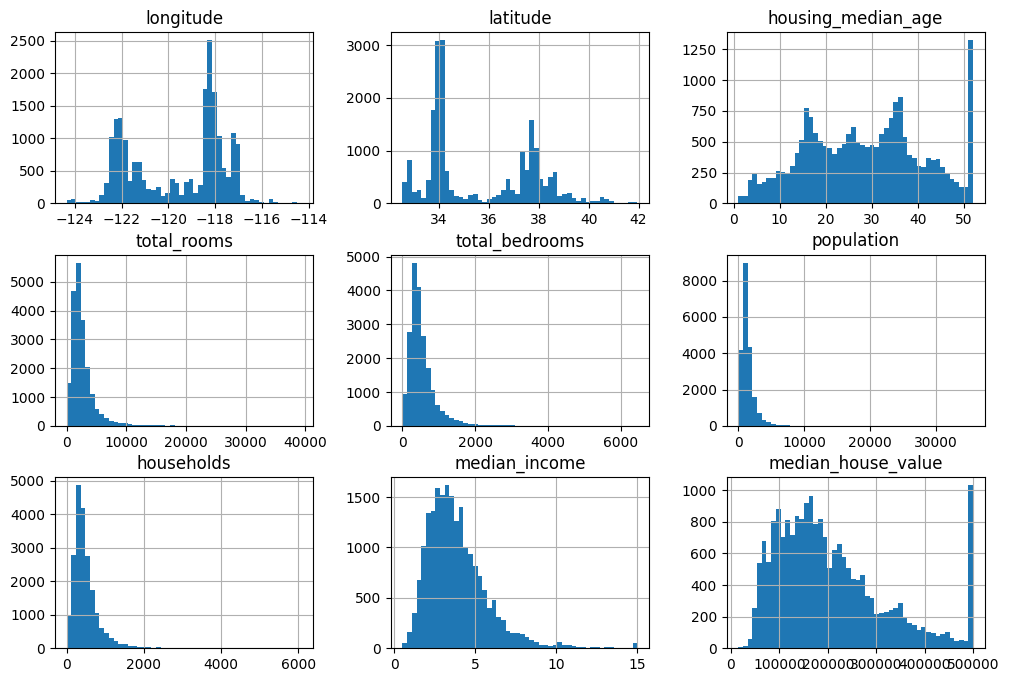

In [80]:
housing_full.hist(bins=50, figsize=(12,8))
plt.show()

### Create a Test Set
Put some data aside and never look at it to avoid overfitting, or data-snooping bias.
There are a variety of ways to create test sets:

**Random Picking**
- Should set a seed so that rng function provides the same numbers every time
- Would break if you fetch an updated dataset, can use hashing or any unique and immutable identifers

In [81]:
# Select 20% of dataset or less if very large and set aside

def shuffle_and_split_data(
        data: pd.DataFrame, 
        test_ratio: float, 
        rng: np.random.Generator
        ) -> tuple[pd.DataFrame, pd.DataFrame]:
    shuffled_indices = rng.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

rng = np.random.default_rng(seed=42)
train_set, test_set = shuffle_and_split_data(housing_full, 0.2,rng)
len(train_set)
len(test_set)

4128

**Use scikit-learn to split datasets as well**

In [82]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)

Using random sampling can introduce sampling bias, want our sampling to be representative of the whole population.

Use stratified sampling
- Population divided into homogenous subgroups (strata)
- Right number of instances are sampled from each stratum to guarantee representation of overall population.

Lets say: Median income is a very important attribute to predict house prices according to experts.
- Because median income is continous, want to create income category attribute

Use `pd.cut()` to create income category. 5 in total labled 1-->5.

1: 0--> 1.5, 2: 1.5 --> 3 etc.

In [83]:
# Create new attribute in data called income_cat
housing_full["income_cat"] = pd.cut(housing_full["median_income"],
                                    bins=[0,1.5,3.0,4.5,6.,np.inf],
                                    labels=[1,2,3,4,5])                                 

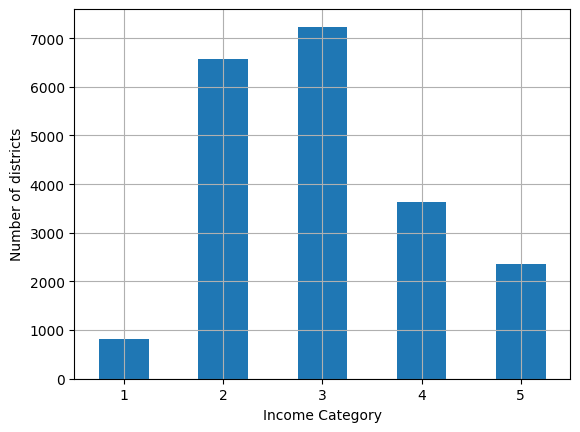

In [84]:
cat_counts = housing_full["income_cat"].value_counts().sort_index()
cat_counts.plot.bar(rot=0, grid=True);
plt.xlabel("Income Category");
plt.ylabel("Number of districts");
plt.show()

Now can do stratified sampling using `sklearn.model_selection`

Each splitter has their own `split()` method that returns iterator over different traning/test splits of the same data.

**Important:** `split()` returns indices and not the data itself

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing_full,
                                              housing_full["income_cat"]):
    strat_train_set_n = housing_full.iloc[train_index]
    strat_test_set_n = housing_full.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [86]:
# For now, use first split
strat_train_set: pd.DataFrame
strat_test_set: pd.DataFrame
strat_train_set, strat_test_set = strat_splits[0]

# A shorter way to get a single split is to use the train_test_split() function --
# with startify argument
strat_train_set, strat_test_set = train_test_split(housing_full, test_size=0.2, 
                                                   stratify=housing_full["income_cat"],
                                                   random_state=42)

# Won't use income_cat column again, remove it from dataframe of test and train sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Explore and Visualize the Data to Gain Insights

In [87]:
# Create copy we will use in this section
housing: pd.DataFrame = strat_train_set.copy()

### Geographical Data
Dataset includes geographical information (latitude, longitude), can create a scatterplot to visualize data

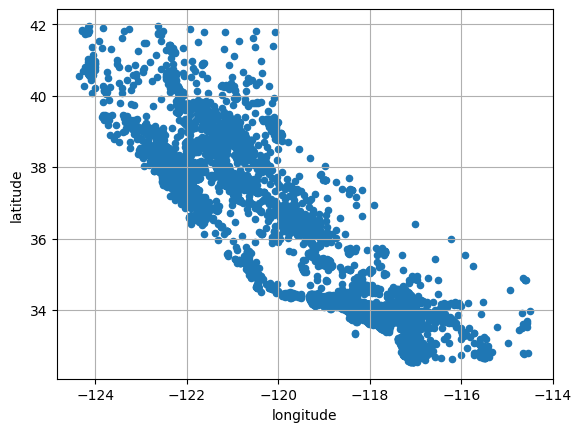

In [88]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

To better show a pattern (density), set alpha to be 0.2 to the plot

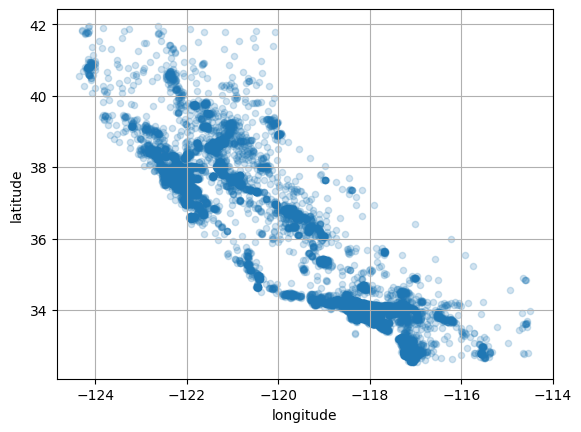

In [89]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

Can add additional options:
- `s`: Radius of circle represents district population
- `c`: color to represent price
- `cmap`: Use jet as color mappings

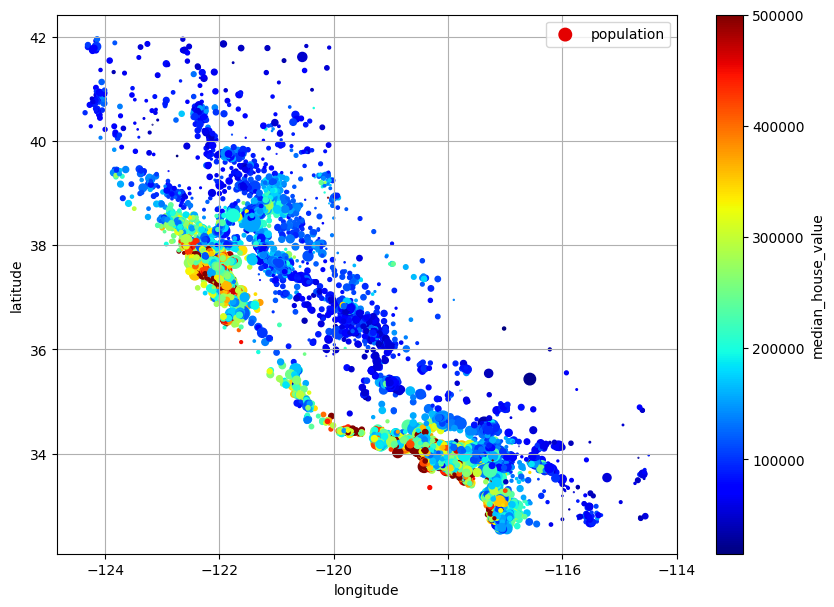

In [90]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

### Looking for Correlations
Dataset not too large, can compute standard correlation coefficient (Pearson's r) between every pair of numerial attributes with median house value using the `corr()` method.

Outputs how every feature correlates with output, will see that:
- Prices tend to go down when you go north
- Median house values tends to go up when median income goes up

In [91]:
corr_matrix : pd.DataFrame = housing.corr(numeric_only=True)

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Can also use pd `scatter_matrix()` function, which plots every attribute against every other numerical attribute.

9 input features, get $9^2$ = 81 plots. Focus on what seems to be most correlated with median house value such as
- Median house value
- Median income
- Total rooms
- Housing median age

Ignore the main diagonal as it's just a variable compared to itself

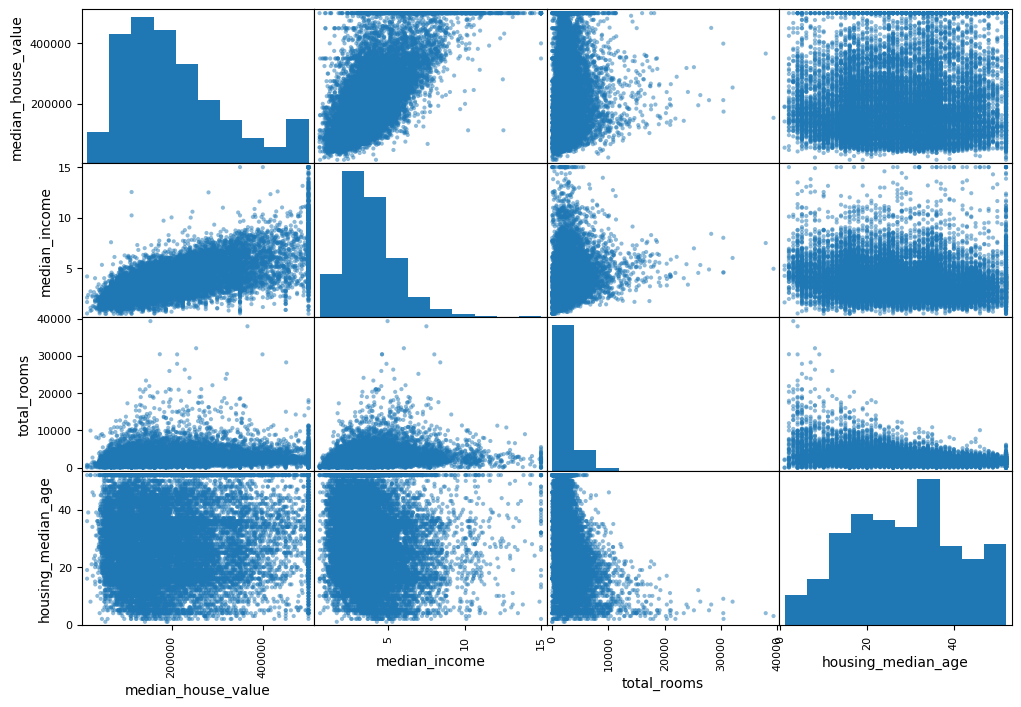

In [92]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

We see that median income - Median houe value  seems the most promising, lets take a look at it.

Notice:
- Clear upward trend even though data is noisy
- Price cap clearly noticable
- There seems to be visible horizonal lines at 500k, 450k, 350k, 280k. May want to remove districts that show these horizontals

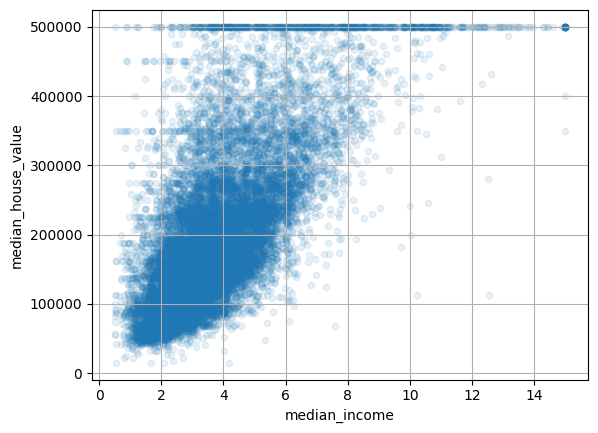

In [93]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

Correlation is not perfect, not a good predictor if relationship is not linear.

Notice now in the following image
1. Bottom row, r = 0 even though there are clear relationshiops
2. Second row: r = 1 or -1 is not dependent on slope

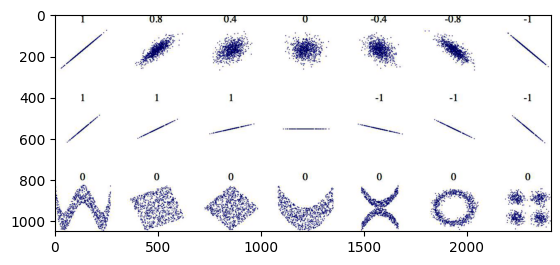

In [94]:
import matplotlib.image as mpimg
img = mpimg.imread("001Graph.png");
plt.imshow(img)
plt.show()

## Experiment with Attribute Combinations
Last thing you might want to do before preparing data for ML algorithms is to try out various attribute combinations

Eg. Total number of rooms in district not very useful if you don't know how many household there are. (What if you want number of rooms per household).

Total # of bedrooms by itself not very useful, maybe want to compare total number of rooms.

Population per household might also be an intersting attribute combination

In [95]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

We can see that bedroom_ratio is much more correlated with median house value than total number of rooms or bedrooms. Strong negative correlation

We can also see that number of rooms per household is more informative than total numbers of rooms. Larger the house, more expensive it is

**Important**: When creating combined features, make sure they are not too linearly correlated with existing features. Can cause collinearity issues with some models such as linear regression. Avoid weighted sums of existing features

## Prepare Data for ML Algorithms
Do not do manually, should write functions
- Allow reproduction of transformations easily on any dataset (eg getting fresh dataset)
- Gradually build library of transformations to use in future projects
- Use functions in live systems to transfrom new data before feeding it to algorithm
- Easy to try various transformations and see which combinations works the best

In [96]:
# Get clean traning set, 
# should seperate predictors (inputs) and labels (outputs)

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Clean data
ML algorithms cannot work with missing features, remember that total_bedrooms has missings values, can fix by:
1. Get rid of corresponding districts
2. Get rid of whole attribute
3. Set missing values to some value (zero, mean, median, etc) (imputation)

In [97]:
housing.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing.drop("total_bedrooms", axis=1, inplace=True)  # option 2
housing = strat_train_set.drop("median_house_value", axis=1)

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median)


We will go with option 3, least destructive.

Instead of using preceding code, can use Scikit-Learn's `SimpleImputer`. Will store meidan value of each feature making it possible to impute missing values on training, validation, and test sets and any new data fed to model

In [98]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Median can only be computer with numerical attributes, 
# need to create copy of data with only numerical attributes

housing_num = housing.select_dtypes(include=[np.number])

# Fit imputer instance to training data using fit() method
imputer.fit(housing_num);

Imputer stores results in `statistics_` instance variable.

Only `total_bedrooms` had missing values, but cannot be sure that would be the only attribute with missing values in any new/ updated datasets when doing batch / live learning.

Safer to apply imputer to all numerical attributes

`sklearn.impute` package has more powerful imputers as well
- `KNNImputer` replaces each missing value with the mean of the k nearest neighbors' value for that feature. Distance based on all available features
- `IterativeImputer` trains regression model per feature to predict mising values based on other features. Repeats several times on updated data and improves on each iteration.

**Now** can use "trained" `imputer` to transform training set by replacing missing values with learned medians:

In [99]:
from typing import cast
X : np.ndarray = cast(np.ndarray,imputer.transform(housing_num))
# for type hints purposes, can ignore the cast() function but keep imputer.transform()
# Sklearn transformers output numpyarrays or SciPy sparce matraces, can recover back to 
# DataFrame type

housing_tr : pd.DataFrame = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


### Handling Text and Categorical Attributes
Have only dealt with numerical attributes, but data may contain text such as `ocean_proximity`

ML algorithms prefer to work with numbers, so we can convert it to a number using sklearn `OrdinalEncoder` class

In [100]:
housing_cat = housing[["ocean_proximity"]]
print(housing_cat.head(8))

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:8])
print(ordinal_encoder.categories_)

      ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY
[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


Issue: ML algorithms might assume two nearby values are more similar than distant ones.

Okay for categories like bad, average, good, excellent, but obviously not good for `ocean_proximity` eg. category 0, 4 are more similar than 0, 1.

Solution: Create one binary attribute per category: One attribute equal 1 when category is `<1H OCEAN` 0 otherise, another attribute equals 1 when it is `INLAND` 0 otherwise etc.

One hot encoding, new attributes are sometimes called dummy attributes

Use Sklearn's `OneHotEncoder` class

In [101]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
cat_encoder = OneHotEncoder()
housing_cat_1hot : csr_matrix | np.ndarray = cat_encoder.fit_transform(housing_cat)
# Output is sparse matrix for efficient memory usage and computation.
print(type(housing_cat_1hot))

# can convert to dense array using the toarray() method
if isinstance(housing_cat_1hot, csr_matrix):
    print(housing_cat_1hot.toarray())
    print("Yamom")
else:
    print(housing_cat_1hot)

# Or set sparse_output=false when initializing encoder class
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot_dense : np.ndarray = cat_encoder.fit_transform(housing_cat)

<class 'scipy.sparse._csr.csr_matrix'>
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Yamom


In [102]:
# Pandas has function called get_dummies(), converts each categorical one hot representaion
#with one binary feature per category
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
print(pd.get_dummies(df_test))




   ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                    True                     False
1                   False                      True


### Feature Scaling and Transformations
Input numerical attributes should have similar scales
Notice: Number rooms range from 6-39,320, median income 0-15
- Means that learning algorithms will bias ignoring median income and favor number of rooms

Fix using:
- min-max(normalization)
    - Values shifted and rescaled so it is between 0-1 `(val[i] - min) / (max-min)`
    - Use Scklearn `MinMaxScaler`, has `feature_range` hyperparamter to change range from 0-1 to some other else.
- standardization
    - Subtract mean value from all data points
    - Divide result by standard deviation
    - Results in dataset with mean = 0, and standard deviation = 1
    - Does not clamp values and is less affected by outliers

In [103]:
# Min Max
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

hnms = pd.DataFrame(housing_num_min_max_scaled, columns=housing_num.columns,
                          index=housing_num.index)

hnms.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
14973,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
3785,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369
14689,0.468560,-0.744681,-0.372549,-0.787782,-0.726204,-0.774015,-0.709166,-0.756983
20507,0.257606,-0.740426,0.372549,-0.778015,-0.610243,-0.765796,-0.562815,-0.582171


In [104]:
# Standardization
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

hnss : pd.DataFrame = pd.DataFrame(housing_num_std_scaled, columns=housing_num.columns,
                                   index=housing_num.index)

hnss.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


**Problem** with min-max and standardization is that for features with a heavy tail, it will squash most values into a small range which is generally not too good for ML algorithms.

Solution to this is transform the features so that it shrinks the heavy tail to make it roughly symmetrical.
- Positive features with heavy tail to the right is to replace it with its square root or any power between (0-1).
- If feature tail is very long and heavy (power law distribution), it may help to use the logarithm

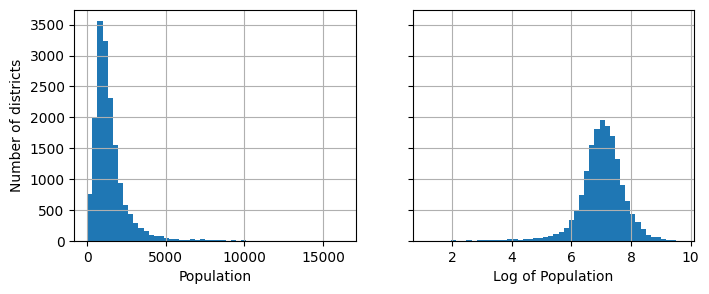

In [105]:
##eg.
fix, axs = plt.subplots(1,2, figsize=(8,3),sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of Population")
axs[0].set_ylabel("Number of districts")

plt.show()

Or you can bucketize the feature
- Chop distribution into roughly equal sized buckets, and replace each feature value with the index of the bucker it belongs to like stratificvation.
- Or can replace each value with its percentile, will result in features with an almost uniform distribution so no need for further scaling. Or divide by num bucket to force values between 0-1

If features has multimodal distribution (two or more clear peaks (modes)), should bucketize it
- reat bucket IDs as categories rather than numerical values --> OneHotEncoder

Or can transform multimodal distribution to add a feature for each of the main nodes
- Can represent similarity between housing median age and that particular mode.
- Similarity measure computed using radial basis function RBF.

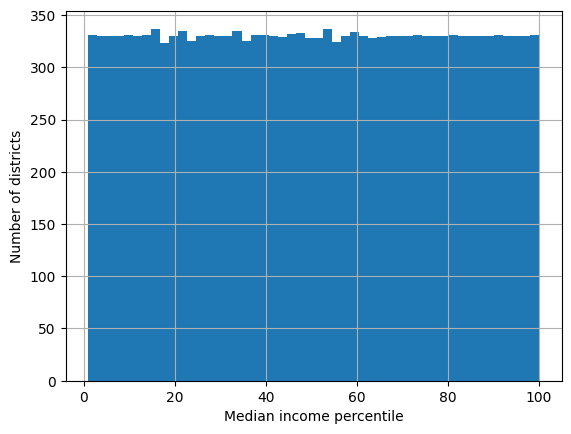

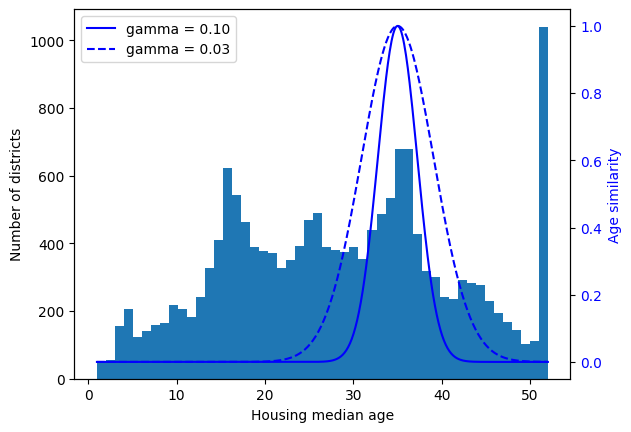

In [106]:
# Percentiles
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

from sklearn.metrics.pairwise import rbf_kernel

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")

plt.show()


We can see that new age similarity peaks at 35, around the spike in housing median age distribution.

If this particualr age group is well correlated with lower prices, good chance that this new feature will help

Output / target values may also need to be transformed as well.
- If target distribution has heavy tail, may want to replace with with logarithm, with **means** you will predict the log of the median house value, not the median house value itself. Computer exponential of model's prediction if you want actual predicted house value

-Sklearn transformers have `inverse_transform()` method
    - Eg, if we used `StandardScaler` for output, and then train a linear regression model on resulting scaled labels, then use it to predict data using the `inverse_transform()` method.

In [107]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
# Remember housing label was a Pandas series, we need to convert to dataframe since
# Standard scaler expects 2d inputs
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model : LinearRegression = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] ## Pretend this is new dta

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

print(predictions)

[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


You can also use a simpler and less error prone `TransformedTargetRegressor` to avoid potential scaling mismatches.
- Need to contruct it giving regression model and label transformer
- Then fit on training set using original unscaled labels.
- Will automatically use transformer to scale labels and train model
- Then to make prediction, just call the model's predict method and using inverse transform to produce prediction

In [108]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), 
                                   transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)

prediction = model.predict(some_new_data)

print(some_new_data)
print(predictions)

       median_income
13096         2.0987
14973         6.0876
3785          2.4330
14689         2.2618
20507         3.5292
[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


### Custom Transformers
Occasionally you want to write your own custom transformations, cleanup operations, or combining specific attributes

For transformations that don't require training, can write function that takes NumPy array as input and outputs the transformed array.

In [109]:
# Log transformed population feature

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

print(log_pop)

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

# How to add feature that measure the geographic similiarity between each district and SF
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

       population
13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905
...           ...
14207    6.843750
13105    7.257708
19301    7.942362
19121    7.452982
19888    6.525030

[16512 rows x 1 columns]


What if you would like your transformer to be traininable?

Learning some parameters in `fit()` method and using them later in `transform()` method?

Need to write custom class

Sklearn relies on duck typing, custom classes do not have to inherit from any particular base class.

Just need 3 methods
1. `fit()` which must return `self`
2.  `transform()` and `fit_transform()`
    - Get `fit_tranform()` for free by adding `TransformerMixin` as base class.
    - If you add `BaseEstimator` as base class (and avoid using `*args and **kwargs`) in constructor, you get two extra methods `get_params()` and `set_params()`

In [110]:
# eg. Custom Standard Scaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): #no *args or **kwargs
        self.with_mean = with_mean
    
    def fit(self, X, y=None):
        X = check_array(X) # Check X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit
        return self
    
    def transform(self, X):
        check_is_fitted(self) #looks for learned attributes with trailing _
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    


The sklearn.utils.validation package contains several functions we can use to validate the inputs. For simplicity, we will skip such tests in the rest of this book, but production code should have them.

This implementation is not 100% complete: all estimators should set feature_​names_in_ in the fit() method when they are passed a DataFrame. Moreover, all transformers should provide a get_feature_names_out() method, as well as an inverse_transform() method when their transformation can be reversed. See the last exercise at the end of this chapter for more details.

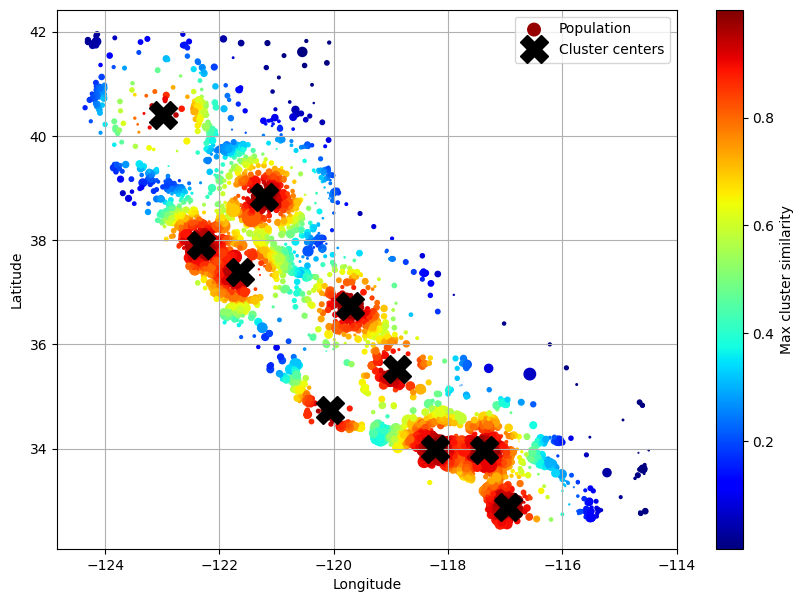

In [111]:
# eg. CusterSimilarity
# Custom transformer can and often does use other estimators in implementation
# Following code uses KMeans clusterer in fit() method to identify main cluster in
# training data. 
# Uses rbf_kernel() in transform() to measure how similar each sample is to each cluster

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self,n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X,sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
# Usage
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")

plt.show()

### Transformation Pipelines

There are many transformation steps that need to be executed in the right order

Sklearn provides `PipeLine` class to help with sequences of transformations.
- Constructor takes a list of name-estimator paris (2-tuple) defining sequence of steps
- Names can be anything you like, as long as unique and don't contain double underscores __
- Estimators must be all transformers (have fit_transform() method) except for the last one, which can be anything.

In [112]:
# Eg. Small pipeline for numerical attributes, impute then scale inpute features

from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

# IF you don't want to name transformers, can use make_pipeline() function instead, uses
# name of transformers' classes in lowercase without underscores eg "simpleimputer"
# If they have the same name, will be indexed eg. foo-1 and foo-2
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

When you call the pipline's `fit()` method, it will call `fit_transform()` sequentially on all transformers, passing output of each call as parameter to the next until the final estimator which just calls the `fit()` method.

Pipeline exposes same methods as final estimator.
- Eg if last estimator is `StandardScaler`, which is a transformer, pipeline also acts like transformer.

In [113]:
#Lets call pipeline's fit_transform() method and see output of first two rows.
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [114]:
# If you want to recover a nice dataframe, can use get_feature_names_out() method
df_housing_num_prepared : pd.DataFrame = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


Pipelines can also be indexed, pipeline[1] returns second estimator, pipeline[:-1] returns PipeLine object containing all but last estiamtor.

Can also access estimator using steps attribute which is a name-estimator pair

Or named_steps dictionary attribute which maps name to estimators

eg. `num_pipeline["simpleimputer"]` returns estimator named "simpleimputer"

To handle categorical and numerical columns in one single trnsformer, we need to apply appropriate transformations to each column. Use `ColumnTransformer` to apply `num_pipeline` and `cat_pipeline` to relevant columns

In [115]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]

cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore"))

# Column transformet takes an array of 3-tuples.
# Each tuple contains a name, a transformer, and a list of 
# names or indices transformer is applied to
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


Listing all column names not very convenient, Sklearn provides `make_column_selctor` class to automatically select all features of a given type.

If you don't care about naming transformers, can use `make_column_transformer()` which chooses the name for you like `make_pipeline()`

In [116]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

housing_prepared = preprocessing.fit_transform(housing)

**Actual Pipeline that we can use**
1. Missing values in numerical features will be replaced with median.
2. Missing categorical values will be replaced with most frequent category
3. Categories will be one hot encoded
4. Few ratios will be computed ad added: `bedroom_ratio`, `rooms_per_house`, and `people_per_house`
5. Few cluster similarity features will be added. Might be more useful to model than latitude and longitude
6. Features with long tail will be replaced by log. Models prefer uniform or gaussian distr.
7. All numerical featuers will be standardized

In [127]:
def column_ratio(X):
    return X[:,[0]] / X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] #feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms",ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                           "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline) # one column remaining: housing_median_age

# By running this, it performs all transformations and outputs numpy array with 24 features
housing_prepared = preprocessing.fit_transform(housing)
print(housing_prepared.shape)

preprocessing.get_feature_names_out()

(16512, 24)


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Select and Train a Model